In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

from climada.hazard import Hazard

tc_wind = Hazard.from_hdf5("./data/tc_wind/tc_wind_SHANSHAN_20240825000000.hdf5")
tc_wind.frequency = np.ones(len(tc_wind.frequency))/51 # change frequency to get the ensemble mean

In [3]:
import numpy as np
from climada.util.coordinates import get_country_code

idx_non_zero_wind = tc_wind.intensity.max(axis=0).nonzero()[1]

country_code_all = get_country_code(tc_wind.centroids.lat[idx_non_zero_wind], 
                                    tc_wind.centroids.lon[idx_non_zero_wind])
country_code_unique = np.trim_zeros(np.unique(country_code_all))


In [4]:
from climada.entity import ImpactFunc, ImpactFuncSet

def impf_step_func(threshold: float = 32.92):

    impf = ImpactFunc.from_step_impf((0,threshold, 100),
                                     haz_type="TC")
    
    impf_set = ImpactFuncSet()
    impf_set.append(impf)

    return(impf_set)

In [5]:
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.coordinates import country_to_iso
client = Client()

impf_set_step = impf_step_func()

imp_per_country_dict = {}

for country_code in country_code_unique:
    try:
        exp = client.get_exposures(exposures_type='litpop',
                                properties={'country_iso3num':[str(country_code)],
                                            'exponents':'(0,1)',
                                            'fin_mode':'pop',
                                            'version':'v2'
                                            }
                                )
    except client.NoResult:
        f"there is no matching dataset in Data API. Country code: {country_code}"
    
    imp_exposed = ImpactCalc(exp, impf_set_step, tc_wind).impact()

    if imp_exposed.aai_agg == 0.0:
        continue
    else:
        imp_per_country_dict[country_to_iso(country_code, "alpha3")] = imp_exposed

2024-11-29 14:13:19,226 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.
2024-11-29 14:13:20,077 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.
2024-11-29 14:13:20,432 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.
2024-11-29 14:13:20,805 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.
2024-11-29 14:13:51,735 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1572514 coordinates.
2024-11-29 14:13:51,862 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 6905 coordinates.


In [6]:
imp_per_country_dict

{'JPN': <climada.engine.impact.Impact at 0x15cadc790>,
 'RUS': <climada.engine.impact.Impact at 0x15db2be10>}

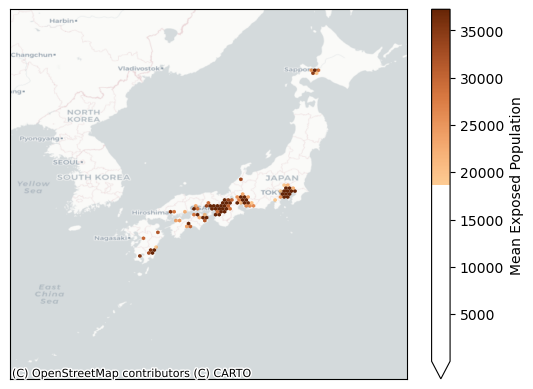

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm_mp
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import contextily as ctx

from climada.util.constants import CMAP_IMPACT, CMAP_EXPOSURES

imp_exp_all = imp_per_country_dict['JPN']._build_exp()
imp_exp_all.set_geometry_points()
#imp_exp =imp_exp_all.gdf[imp_exp_all.gdf.value>0.]

cmap = plt.get_cmap("YlOrBr")
cmap.set_bad("white", alpha=0)
cmap.set_under("white", alpha=0)


fig, ax = plt.subplots()

extent = imp_exp_all.gdf.geometry.to_crs(epsg=3857).total_bounds
imp_exp_all.to_crs("EPSG:3857", inplace=True)
gdf = imp_exp_all.gdf

vmax = np.max(gdf["value"])
vmin = 10 if vmax > 10 else 1
vmax = 10 if vmax < 2 else vmax
extend = "min" if np.min(gdf["value"]) < vmin else None
norm = Normalize(vmin=vmin, vmax=vmax)

colors = cmap(np.arange(cmap.N))
colors[:, -1] = np.linspace(0.0, 1.0, cmap.N)

# Make low values transparent
threshold = vmin
colors[:int(threshold / 20 * cmap.N), -1] = 0.0

transparent_cmap = ListedColormap(colors)

hb = ax.hexbin(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        C=gdf["value"],
        reduce_C_function=np.sum,
        norm=norm,
        gridsize=100,
        extent=(extent[0], extent[2], extent[1], extent[3]),
        lw=0.0,
        cmap=transparent_cmap,
        )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.colorbar(hb, ax=ax, label="Mean Exposed Population", extend=extend)




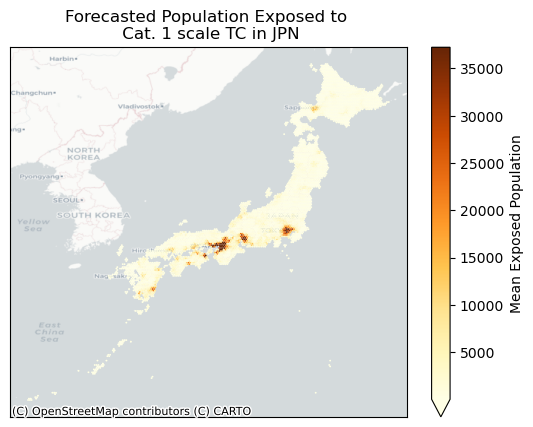

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm_mp
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import contextily as ctx

imp_exp_all = imp_per_country_dict['JPN']._build_exp()
imp_exp_all.set_geometry_points()

extent = imp_exp_all.gdf.geometry.to_crs(epsg=3857).total_bounds
imp_exp_all.to_crs("EPSG:3857", inplace=True)
gdf = imp_exp_all.gdf

cmap = plt.get_cmap("YlOrBr")
n = 256  # Number of discrete colors in the colormap
vals = cmap(np.linspace(0, 1, n))
vals[:, -1] = np.linspace(0.0, 1.0, n)  # Gradual transparency

# Make values below 10 transparent
threshold = 10
alphas = np.ones(n)
alphas[:int(threshold / np.max(gdf["value"]) * n)] = 0.0
vals[:, -1] = alphas

transparent_cmap = ListedColormap(vals)

fig, ax = plt.subplots()

vmax = np.max(gdf["value"])
vmin = threshold  # Start normalization from threshold

norm = Normalize(vmin=vmin, vmax=vmax)

hb = ax.hexbin(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    C=gdf["value"],
    reduce_C_function=np.sum,
    norm=norm,
    gridsize=200,
    extent=(extent[0], extent[2], extent[1], extent[3]),
    lw=0.0,
    cmap=transparent_cmap,
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.colorbar(hb, ax=ax, label="Mean Exposed Population", extend='min')

# get information for the title
mean = int(np.mean(imp_per_country_dict['JPN'].at_event))
std = int(np.std(imp_per_country_dict['JPN'].at_event))

# Main title
ax.set_title(
f"Forecasted Population Exposed to \n Cat. 1 scale TC in JPN"
)

# # box with information
# ax.text(
#     0.03,
#     0.03,
#     f"Valid Date: {valid_date}\nBase Date: {FORECAST_DATE}\n{prot_str}\nEstimated Exposed Population: {mean:,}±{std:,}",
#     transform=ax.transAxes,
#     ha="left",
#     va="bottom",
#     fontsize=10,
#     bbox={"boxstyle": "round", "facecolor": "white"},
#     zorder=10,
# )

plt.show()